Find Metrics most correlated to SBS

In [2]:
#Import Modules
import sys
sys.path.append("..") #give this script access to all modules in parent directory
from pathlib import Path
import matplotlib.lines as mlines
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import math
from scipy.io import loadmat
from scipy.stats import pearsonr
from scipy.stats import spearmanr
from scipy.stats import kendalltau
import tsfel
from operator import itemgetter
import os
from Data_Cleaning import preprocess
import Actigraph_Metrics
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import statistics



C:\Users\jakes\AppData\Local\Temp\ipykernel_17192\22593464.py:7: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [3]:
# signal parameters
freq = 100 #signal is 100hz

Load All Patient Data

In [4]:
#Change to Load data of interest
#data_dir = 'C:/Users/sidha/OneDrive/Sid Stuff/PROJECTS/iMEDS Design Team/Data Analysis/PedAccel/data_analysis/PythonPipeline/PatientData'

data_dir = r'C:\Users\jakes\Documents\DT 6 Analysis\PythonCode\PedAccel\data_analysis\PythonPipeline\PatientData'


#set params
slice_size_min = 10
lead_time = 5
window_size = 100 #100 is 1 second worth of time

In [1]:


#Change for data of interest
#preprocess.load_and_segment_data(data_dir, slice_size_min, lead_time) #take sbs csv and accel gt3x to create a .mat file with vector magnitudes

Generate Most correlated features for some signal 

(25, 59999)
[[1.46346214e-02 3.69283438e-03 6.16499896e-04 ... 6.28425924e-07
  7.20511923e-07 0.00000000e+00]
 [1.32882088e-02 3.07821623e-03 5.13892526e-04 ... 6.28425924e-07
  7.20511923e-07 0.00000000e+00]
 [1.55249390e-02 4.24883979e-03 7.09322169e-04 ... 6.28425924e-07
  7.20511923e-07 0.00000000e+00]
 ...
 [1.45037247e-02 6.45661072e-03 1.07789828e-03 ... 6.28425924e-07
  7.20511923e-07 0.00000000e+00]
 [1.46906662e-02 3.67348291e-03 6.13269268e-04 ... 6.28425924e-07
  7.20511923e-07 0.00000000e+00]
 [1.45037247e-02 6.45661072e-03 1.07789828e-03 ... 6.28425924e-07
  7.20511923e-07 0.00000000e+00]]
x mean should be 0 but is really: -2.0526200106679583e-15
Explained variation per principal component: [0.747832   0.13851569 0.04270128 0.02520611]


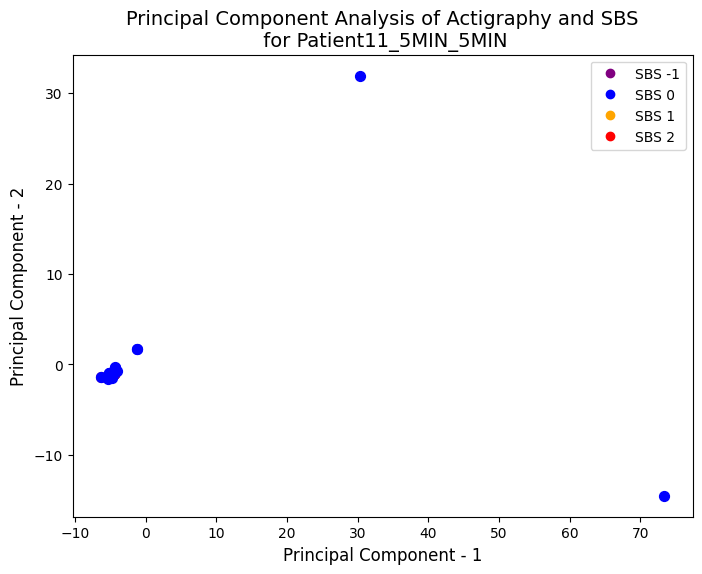

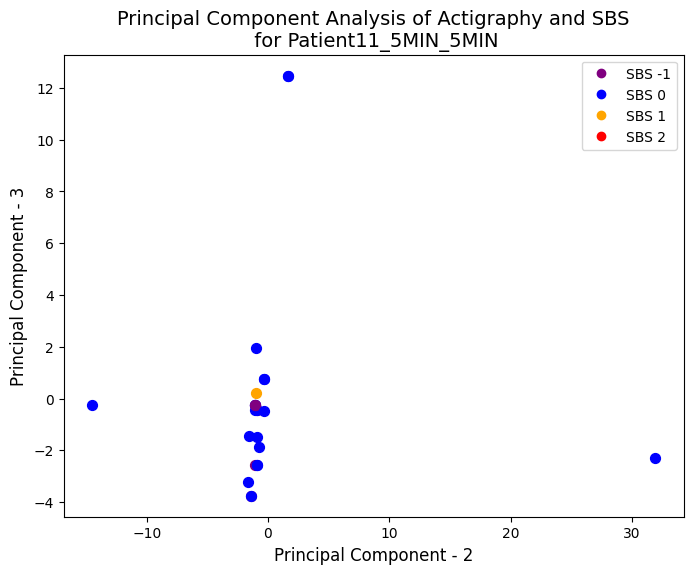

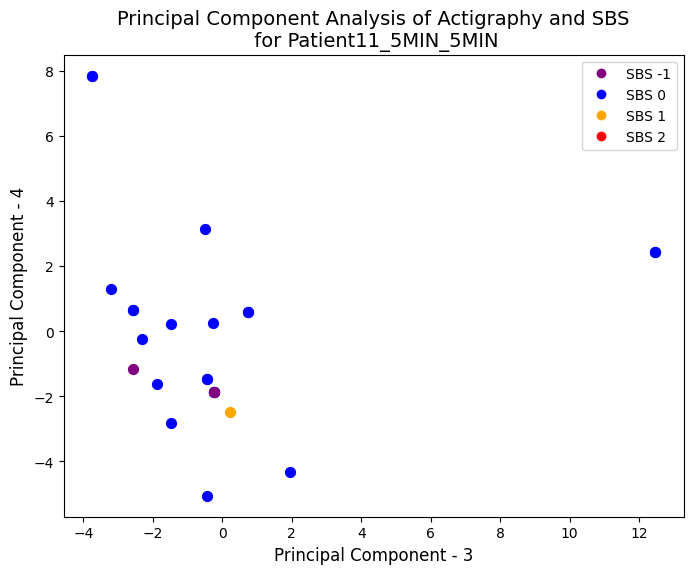

(19, 59999)
[[8.85379586e-02 5.43505399e-01 9.07354590e-02 ... 3.81753160e-04
  3.42859587e-04 0.00000000e+00]
 [2.48880875e-02 1.23200908e-01 2.05677643e-02 ... 3.81753160e-04
  3.42859587e-04 0.00000000e+00]
 [6.07451788e-02 1.32218205e-01 2.20731560e-02 ... 3.81753160e-04
  3.42859587e-04 0.00000000e+00]
 ...
 [1.34512637e-01 1.32840996e+00 2.21771279e-01 ... 3.81753160e-04
  3.42859587e-04 0.00000000e+00]
 [1.56846771e-02 8.87572952e-03 1.48175785e-03 ... 3.81753160e-04
  3.42859587e-04 0.00000000e+00]
 [2.14766788e-02 7.93850521e-02 1.32529302e-02 ... 3.81753160e-04
  3.42859587e-04 0.00000000e+00]]
x mean should be 0 but is really: -2.80634319066812e-16
Explained variation per principal component: [0.48024944 0.14658335 0.10694102 0.0893916 ]


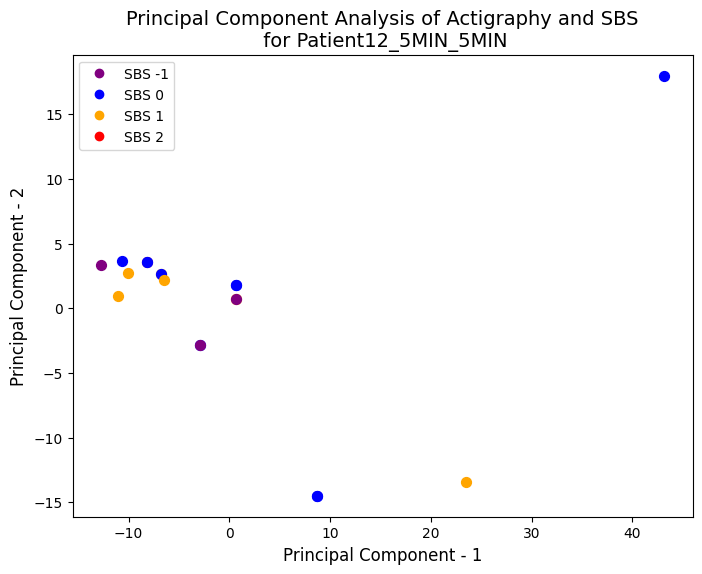

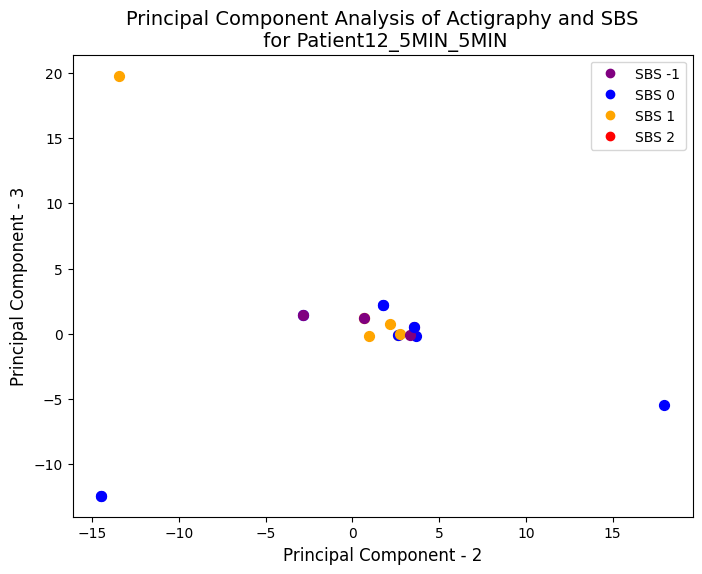

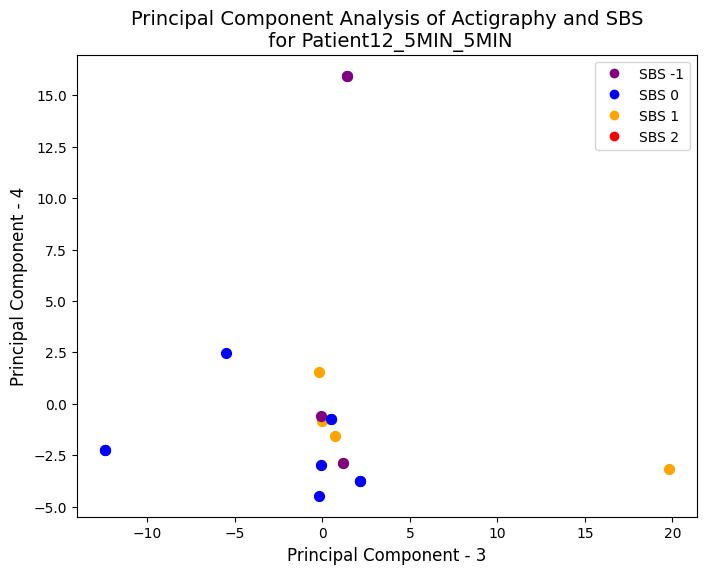

(42, 59999)
[[1.18181849e-01 6.61392659e-01 1.10416137e-01 ... 2.63102184e-05
  2.83733547e-05 0.00000000e+00]
 [1.67224878e-02 9.72113889e-03 1.62289464e-03 ... 2.63102184e-05
  2.83733547e-05 0.00000000e+00]
 [1.25081837e-01 6.44691280e-01 1.07627927e-01 ... 2.63102184e-05
  2.83733547e-05 0.00000000e+00]
 ...
 [1.72372162e-04 5.27673112e-07 8.80923393e-08 ... 2.63102184e-05
  2.83733547e-05 0.00000000e+00]
 [1.10124469e-03 2.16719896e-04 3.61802831e-05 ... 2.63102184e-05
  2.83733547e-05 0.00000000e+00]
 [5.35539448e-03 1.68537699e-03 2.81365106e-04 ... 2.63102184e-05
  2.83733547e-05 0.00000000e+00]]
x mean should be 0 but is really: 2.2467378326862526e-16
Explained variation per principal component: [0.514753   0.11146795 0.08651108 0.04229825]


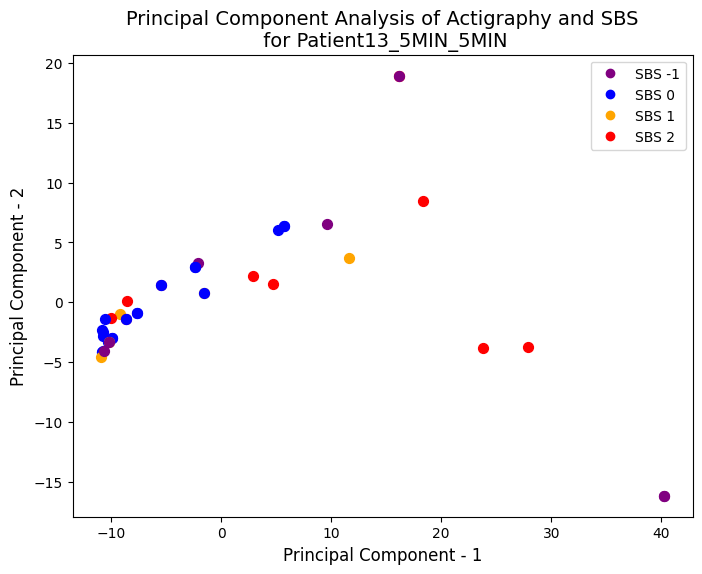

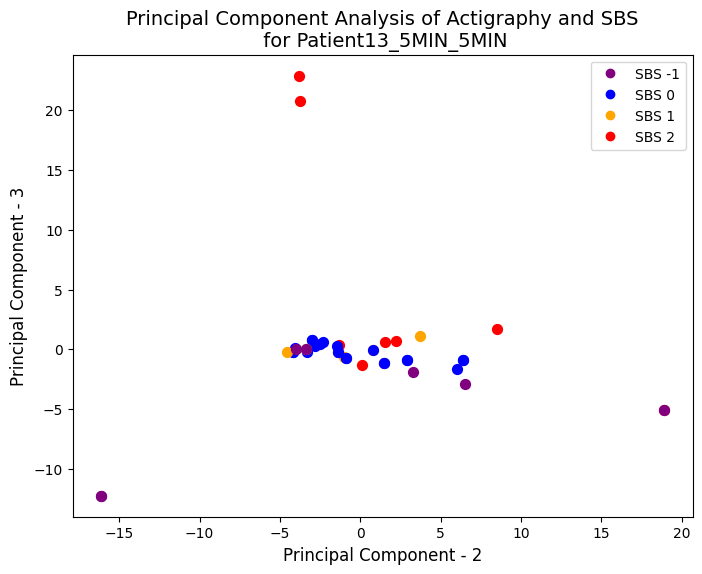

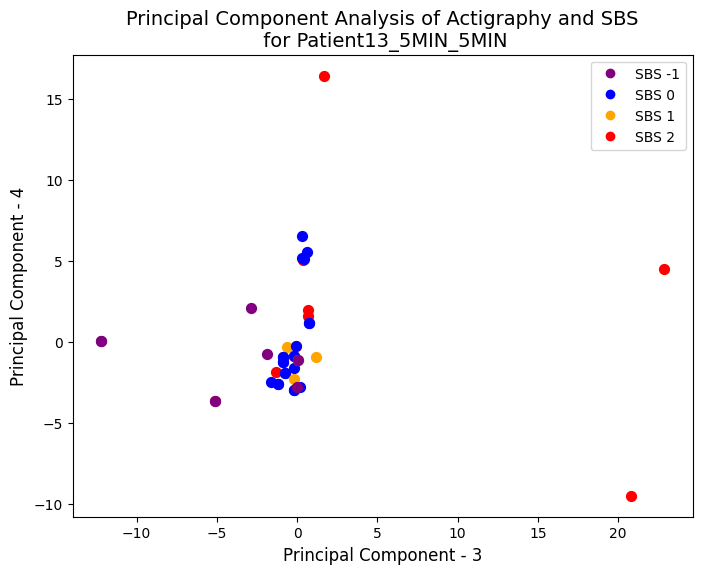

(37, 59999)
[[1.38718766e-02 3.29428134e-03 5.49963496e-04 ... 4.61858743e-07
  5.43508695e-07 0.00000000e+00]
 [1.38718766e-02 3.29428134e-03 5.49963496e-04 ... 4.61858743e-07
  5.43508695e-07 0.00000000e+00]
 [8.74262035e-03 1.33223375e-03 2.22409642e-04 ... 4.61858743e-07
  5.43508695e-07 0.00000000e+00]
 ...
 [3.38935009e-02 1.47004495e-01 2.45416519e-02 ... 4.61858743e-07
  5.43508695e-07 0.00000000e+00]
 [2.57379496e-02 2.34560914e-02 3.91587502e-03 ... 4.61858743e-07
  5.43508695e-07 0.00000000e+00]
 [1.44633228e-02 4.66065538e-03 7.78072685e-04 ... 4.61858743e-07
  5.43508695e-07 0.00000000e+00]]
x mean should be 0 but is really: 1.498598785085048e-15
Explained variation per principal component: [0.83256041 0.0745376  0.03138077 0.01536683]


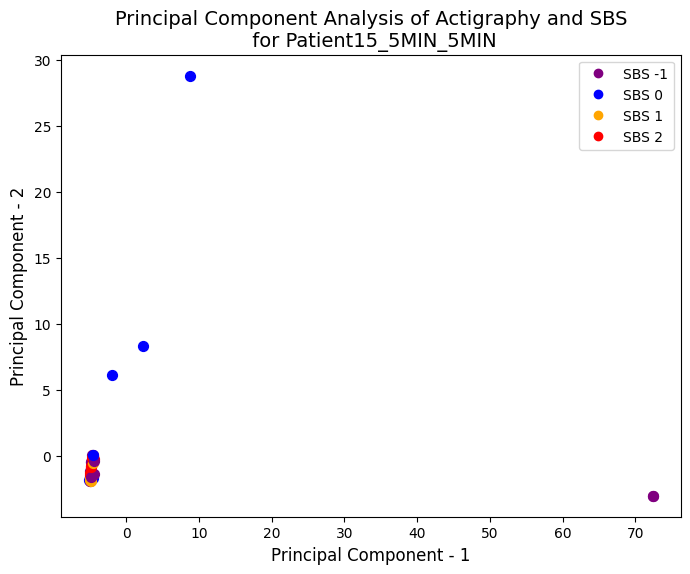

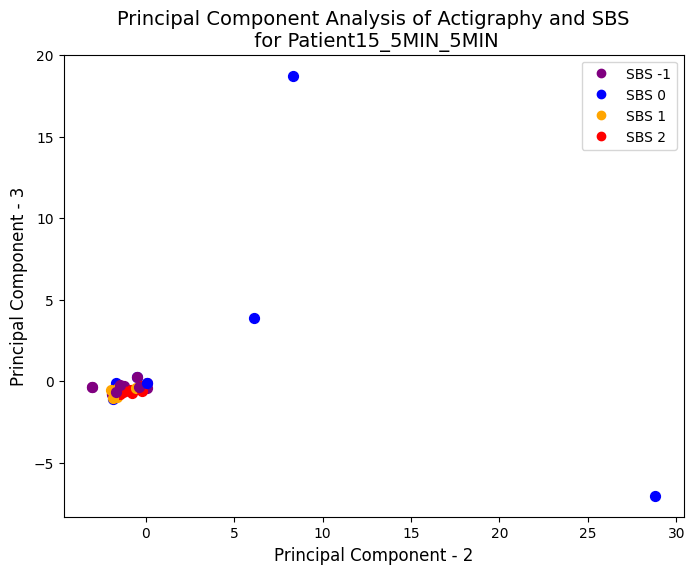

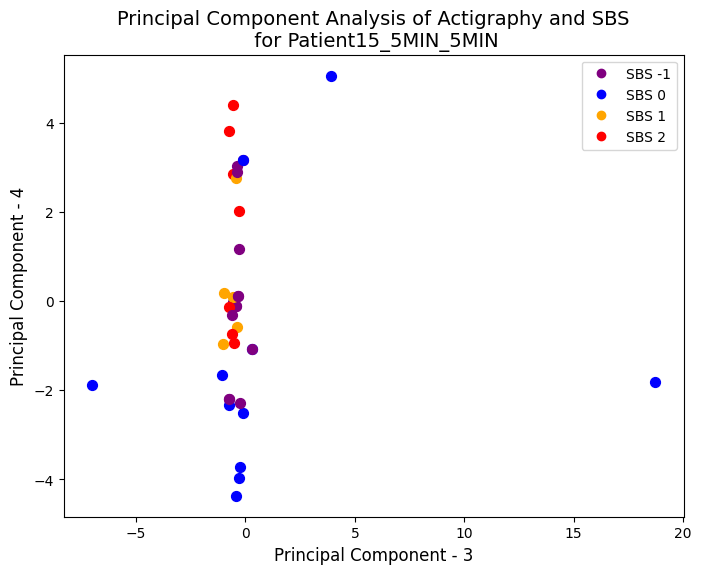

(29, 59999)
[[9.65810567e-02 4.99797699e-01 8.34386810e-02 ... 9.74778458e-04
  1.16128198e-03 0.00000000e+00]
 [9.65810567e-02 4.99797699e-01 8.34386810e-02 ... 9.74778458e-04
  1.16128198e-03 0.00000000e+00]
 [2.62312564e-02 6.81310764e-02 1.13741363e-02 ... 9.74778458e-04
  1.16128198e-03 0.00000000e+00]
 ...
 [7.52746733e-02 4.51772088e-01 7.54210498e-02 ... 9.74778458e-04
  1.16128198e-03 0.00000000e+00]
 [1.71275300e-02 5.07307618e-03 8.46924237e-04 ... 9.74778458e-04
  1.16128198e-03 0.00000000e+00]
 [1.15784515e-02 2.28826610e-03 3.82014375e-04 ... 9.74778458e-04
  1.16128198e-03 0.00000000e+00]]
x mean should be 0 but is really: 2.1159257367552846e-15
Explained variation per principal component: [0.53033897 0.11875407 0.05730202 0.05091923]


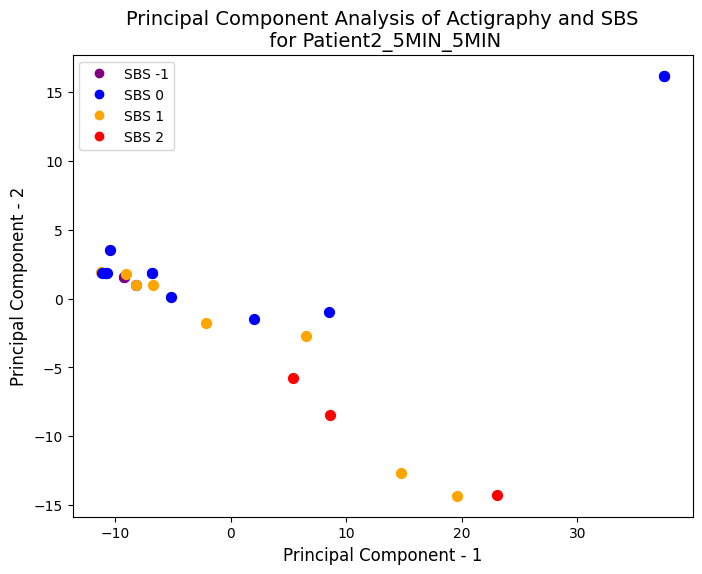

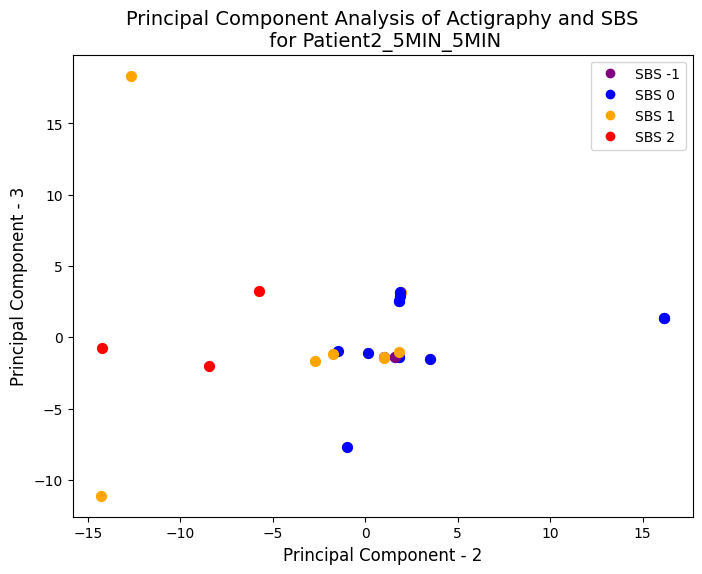

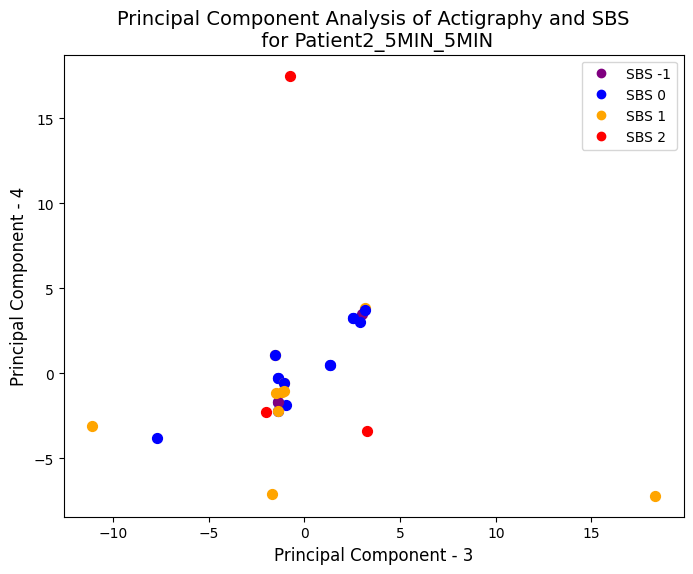

(8, 59999)
[[1.82476258e-02 5.81782527e-03 9.71256306e-04 ... 1.99152840e-05
  2.09116859e-05 0.00000000e+00]
 [3.55271798e-02 2.58132221e-02 4.30938599e-03 ... 1.99152840e-05
  2.09116859e-05 0.00000000e+00]
 [2.62895554e-02 1.19473177e-02 1.99454386e-03 ... 1.99152840e-05
  2.09116859e-05 0.00000000e+00]
 ...
 [6.16565542e-02 1.00268156e-01 1.67392581e-02 ... 1.99152840e-05
  2.09116859e-05 0.00000000e+00]
 [1.82476258e-02 5.81782527e-03 9.71256306e-04 ... 1.99152840e-05
  2.09116859e-05 0.00000000e+00]
 [2.45515630e-02 1.07563092e-02 1.79571105e-03 ... 1.99152840e-05
  2.09116859e-05 0.00000000e+00]]
x mean should be 0 but is really: 1.7876984034388118e-14
Explained variation per principal component: [0.71150164 0.15637492 0.07241232 0.02915254]


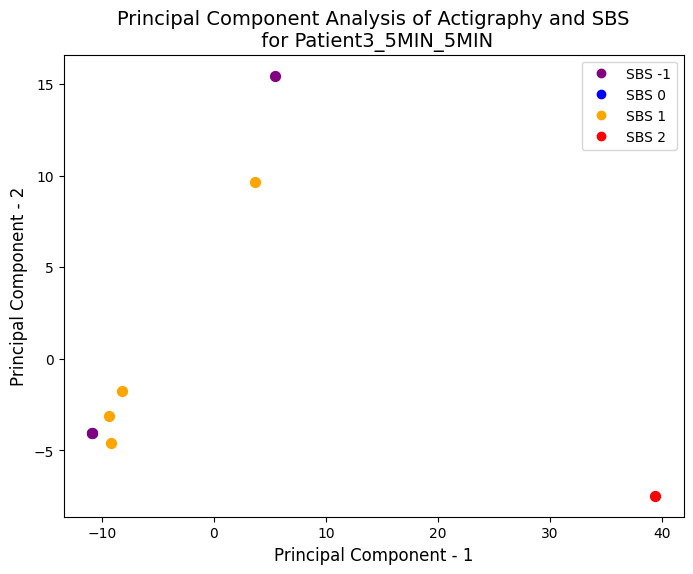

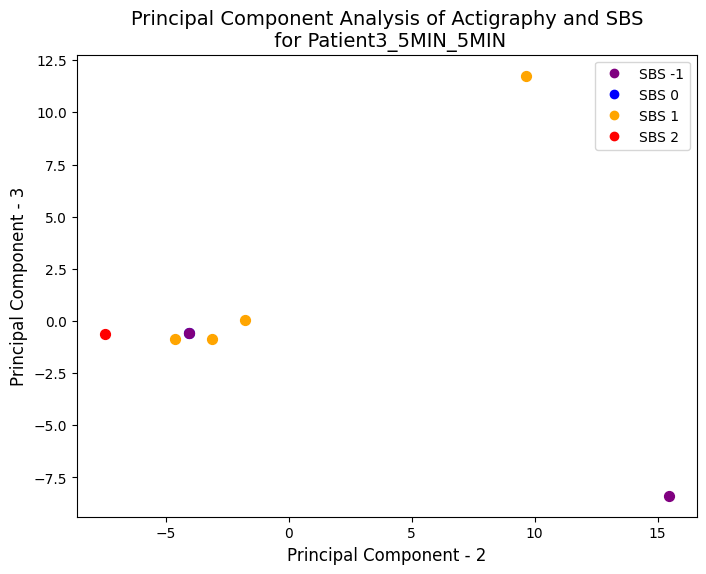

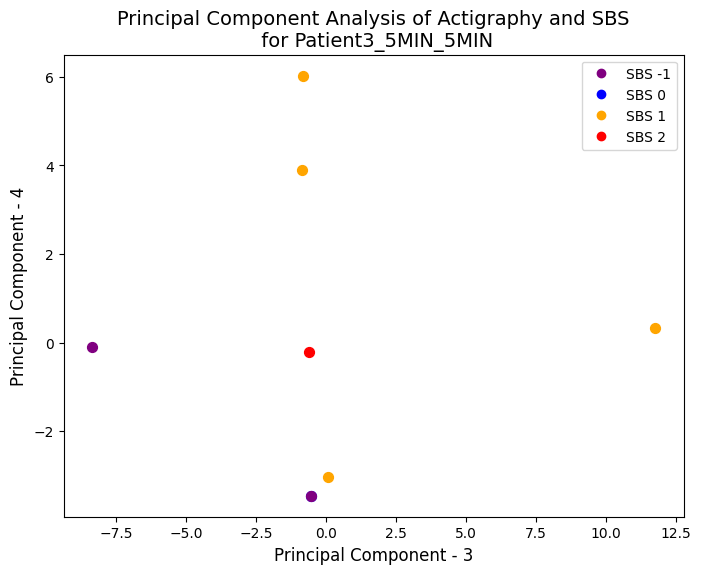

(116, 59999)
[[5.43291318e-02 1.83624995e-01 3.06552579e-02 ... 1.24600185e-04
  1.55316193e-04 0.00000000e+00]
 [3.47150785e-02 4.40085498e-02 7.34700330e-03 ... 1.24600185e-04
  1.55316193e-04 0.00000000e+00]
 [1.67748350e-02 9.54718845e-03 1.59385450e-03 ... 1.24600185e-04
  1.55316193e-04 0.00000000e+00]
 ...
 [1.26271258e-02 2.75774165e-03 4.60390926e-04 ... 1.24600185e-04
  1.55316193e-04 0.00000000e+00]
 [9.66380358e-03 3.19897968e-03 5.34053369e-04 ... 1.24600185e-04
  1.55316193e-04 0.00000000e+00]
 [1.00321734e-02 1.83124567e-03 3.05717140e-04 ... 1.24600185e-04
  1.55316193e-04 0.00000000e+00]]
x mean should be 0 but is really: 3.651895215692096e-15
Explained variation per principal component: [0.52828417 0.07373337 0.04503572 0.04473639]


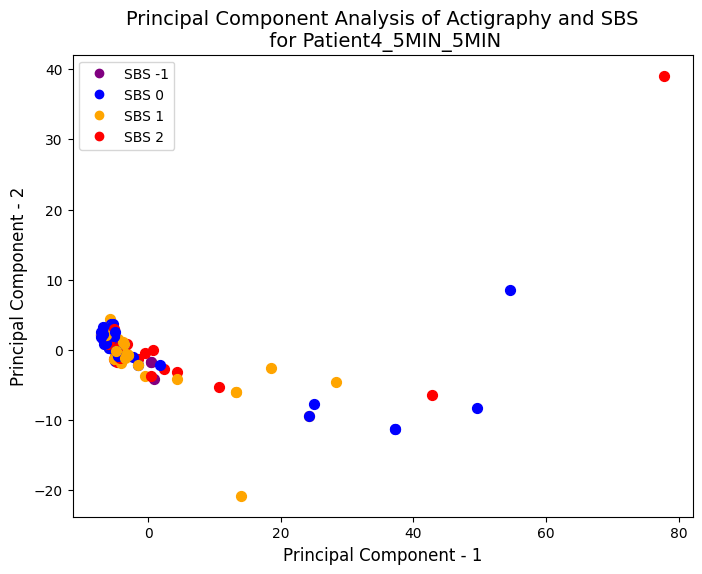

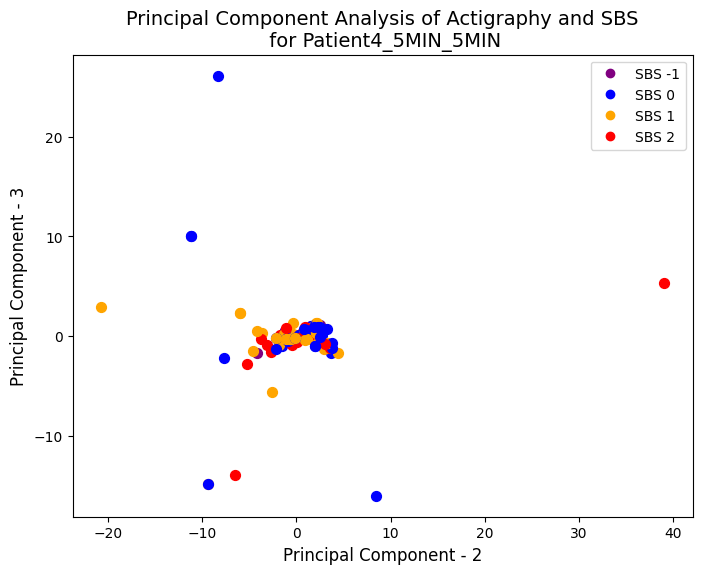

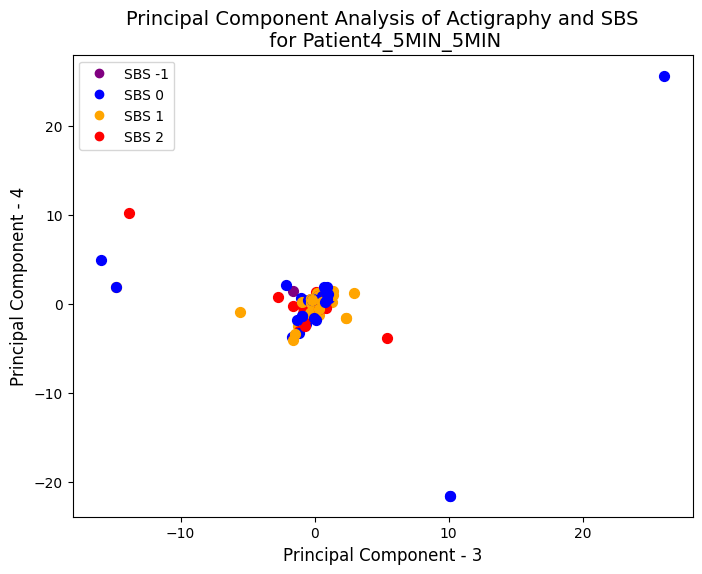

(68, 59999)
[[8.70361099e-02 4.48552383e-01 7.48835364e-02 ... 1.56338446e-03
  1.89973323e-03 0.00000000e+00]
 [1.74731160e-01 7.78272177e-01 1.29928577e-01 ... 1.56338446e-03
  1.89973323e-03 0.00000000e+00]
 [7.99673367e-02 1.34816012e-01 2.25068468e-02 ... 1.56338446e-03
  1.89973323e-03 0.00000000e+00]
 ...
 [1.64800668e-02 4.77338865e-03 7.96892930e-04 ... 1.56338446e-03
  1.89973323e-03 0.00000000e+00]
 [2.60089684e-01 1.98751140e+00 3.31804908e-01 ... 1.56338446e-03
  1.89973323e-03 0.00000000e+00]
 [2.70297340e-02 1.07426349e-01 1.79342820e-02 ... 1.56338446e-03
  1.89973323e-03 0.00000000e+00]]
x mean should be 0 but is really: -1.386624991423035e-15
Explained variation per principal component: [0.53637305 0.10426656 0.07085023 0.04559216]


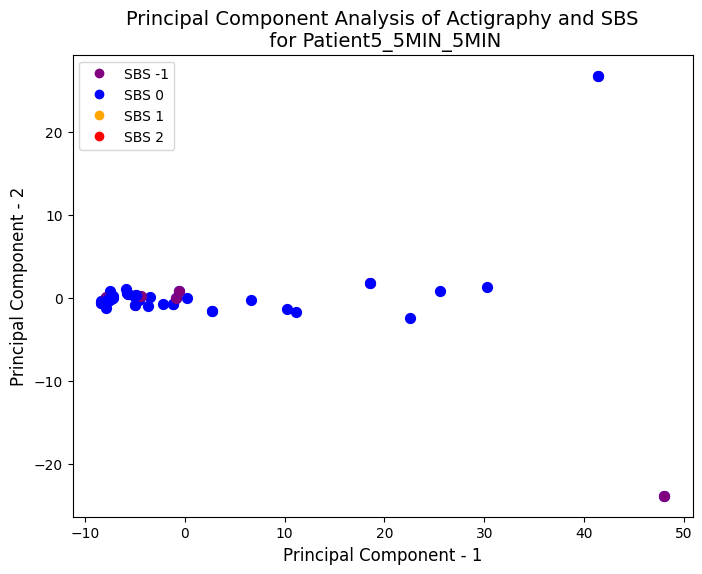

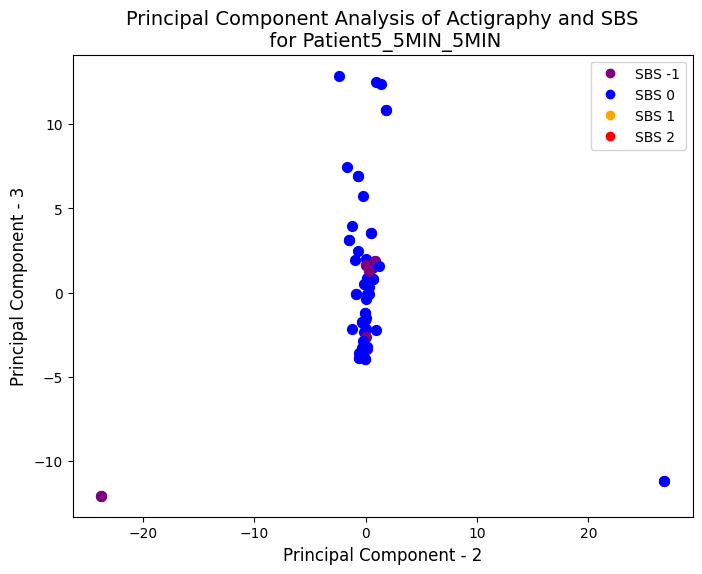

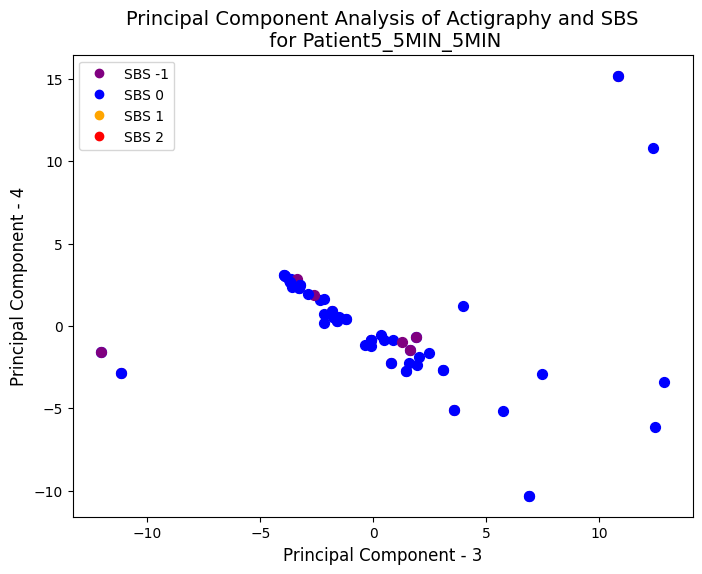

(7, 59999)
[[0.01695554 0.00691296 0.00115408 ... 0.00051332 0.00055904 0.        ]
 [0.03468956 0.0922983  0.01540873 ... 0.00051332 0.00055904 0.        ]
 [0.01695554 0.00691296 0.00115408 ... 0.00051332 0.00055904 0.        ]
 ...
 [0.01496159 0.00432479 0.000722   ... 0.00051332 0.00055904 0.        ]
 [0.0373759  0.05459632 0.00911458 ... 0.00051332 0.00055904 0.        ]
 [0.0373759  0.05459632 0.00911458 ... 0.00051332 0.00055904 0.        ]]
x mean should be 0 but is really: 5.209115396259835e-15
Explained variation per principal component: [6.77070092e-01 2.82359126e-01 4.05707821e-02 1.14276021e-33]


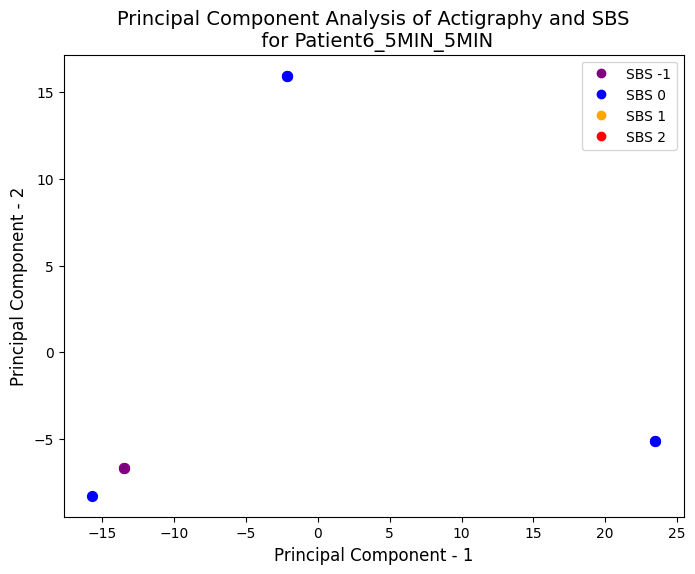

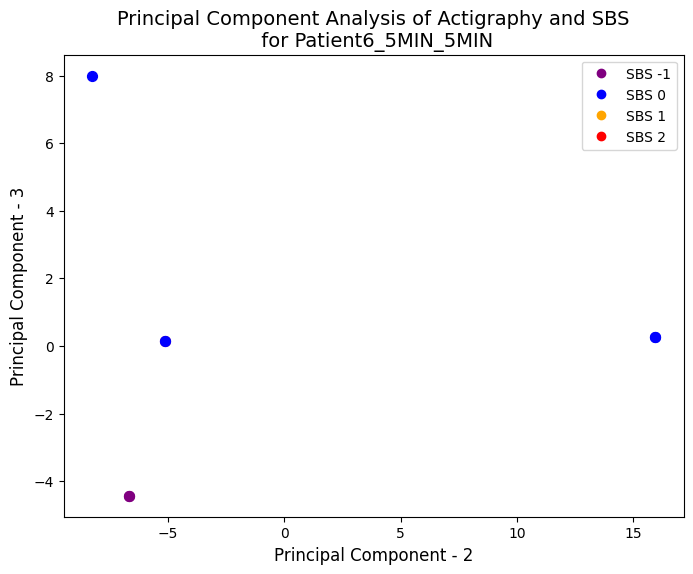

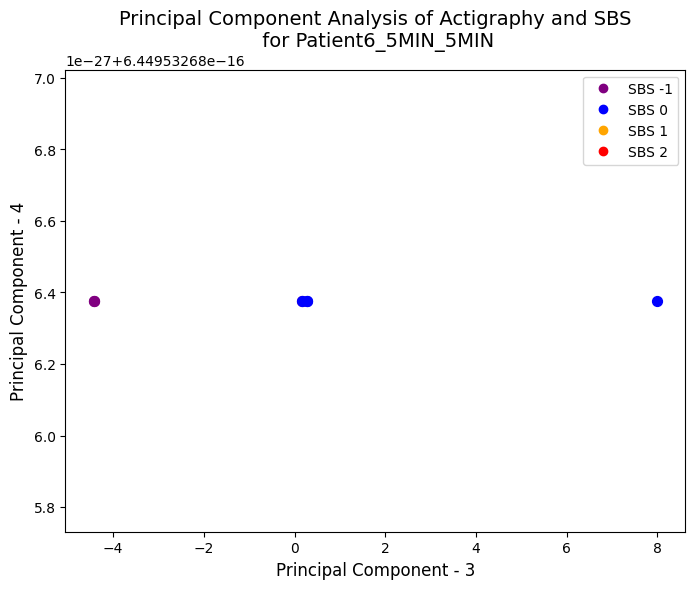

(4, 59999)
[[1.50167921e-02 3.99969610e-03 6.67728899e-04 ... 5.04581274e-03
  5.74765592e-03 0.00000000e+00]
 [1.90197745e-01 1.50848369e+00 2.51833671e-01 ... 5.04581274e-03
  5.74765592e-03 0.00000000e+00]
 [3.42023459e-02 1.26508124e-01 2.11198871e-02 ... 5.04581274e-03
  5.74765592e-03 0.00000000e+00]
 [1.82200652e-01 1.67118817e+00 2.78996356e-01 ... 5.04581274e-03
  5.74765592e-03 0.00000000e+00]]
x mean should be 0 but is really: 4.2501394938835626e-16
Explained variation per principal component: [6.22645686e-01 2.72589555e-01 1.04764759e-01 6.24950673e-32]


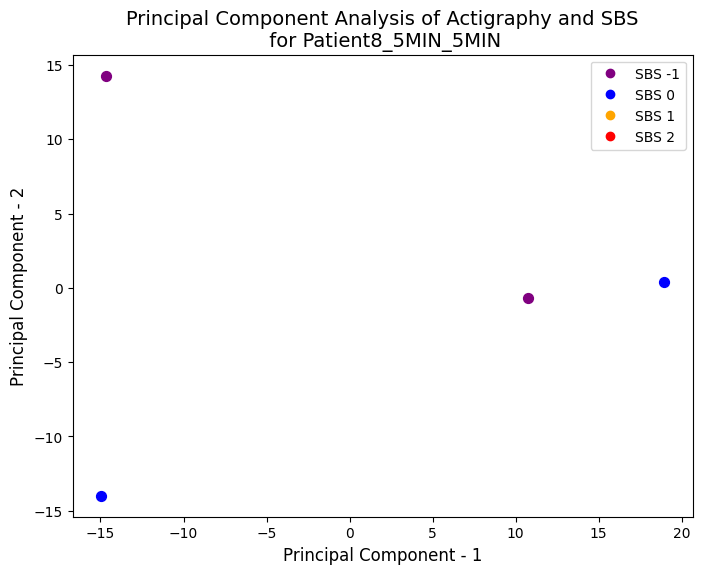

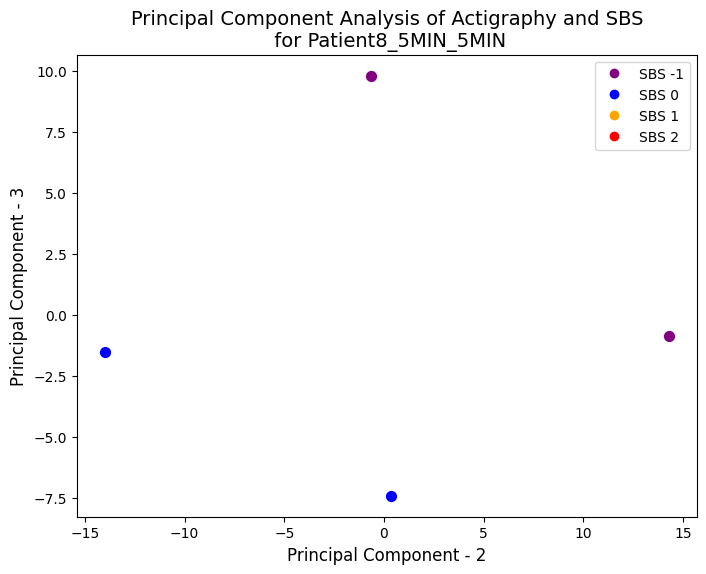

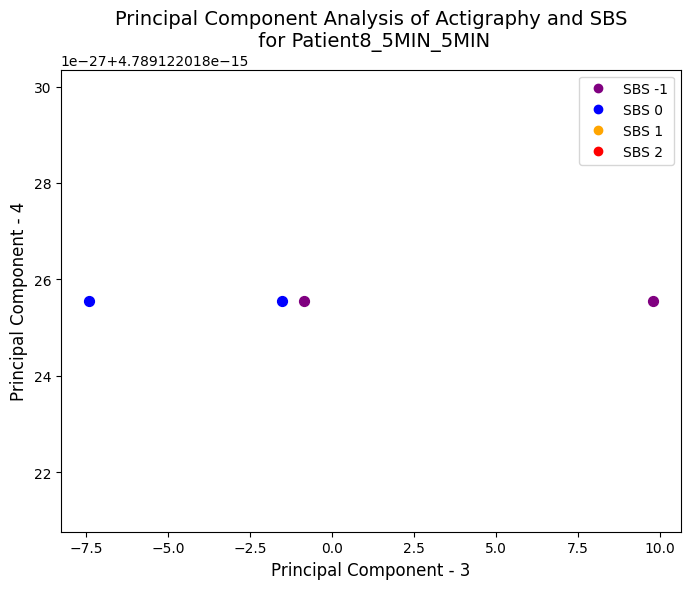

(24, 59999)
[[1.57338506e-02 5.76027582e-03 9.61648719e-04 ... 2.72892403e-06
  2.65018679e-06 0.00000000e+00]
 [1.50152972e-02 4.62565430e-03 7.72229433e-04 ... 2.72892403e-06
  2.65018679e-06 0.00000000e+00]
 [1.44756159e-02 6.84517804e-03 1.14276762e-03 ... 2.72892403e-06
  2.65018679e-06 0.00000000e+00]
 ...
 [1.47184116e-02 5.80283916e-03 9.68754451e-04 ... 2.72892403e-06
  2.65018679e-06 0.00000000e+00]
 [1.48445871e-02 4.85915326e-03 8.11210895e-04 ... 2.72892403e-06
  2.65018679e-06 0.00000000e+00]
 [1.18339777e-02 2.41245339e-03 4.02746809e-04 ... 2.72892403e-06
  2.65018679e-06 0.00000000e+00]]
x mean should be 0 but is really: -1.850276713472288e-15
Explained variation per principal component: [0.53421333 0.12617721 0.09094118 0.07702422]


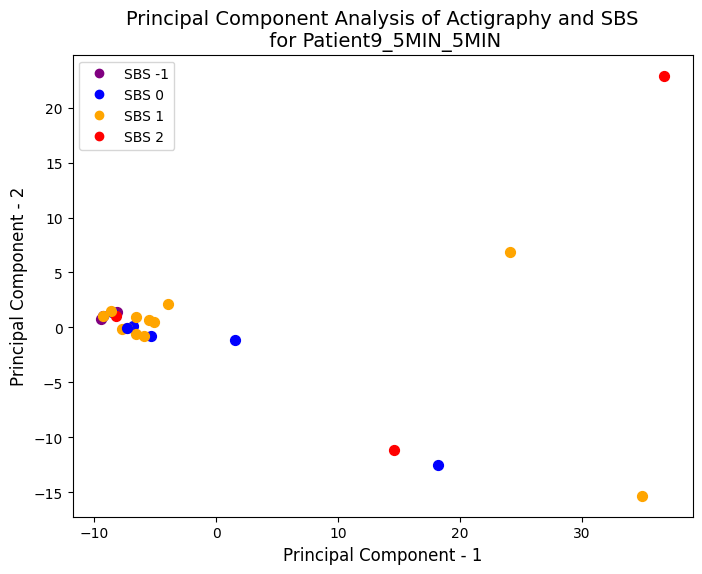

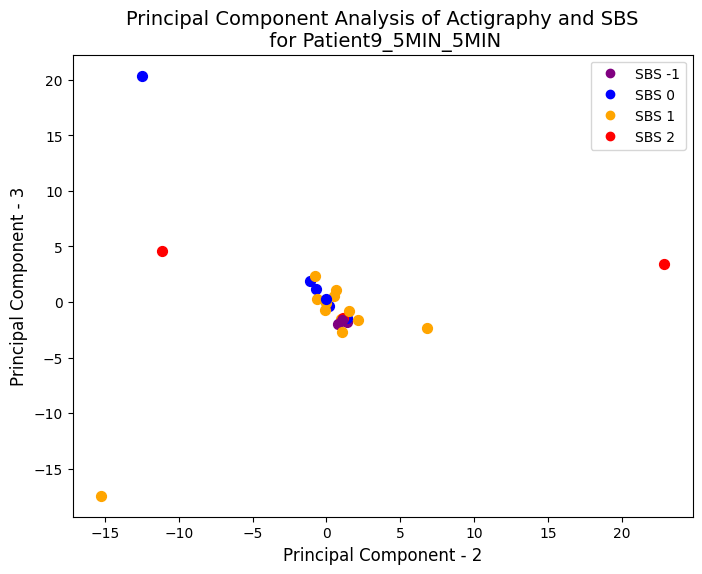

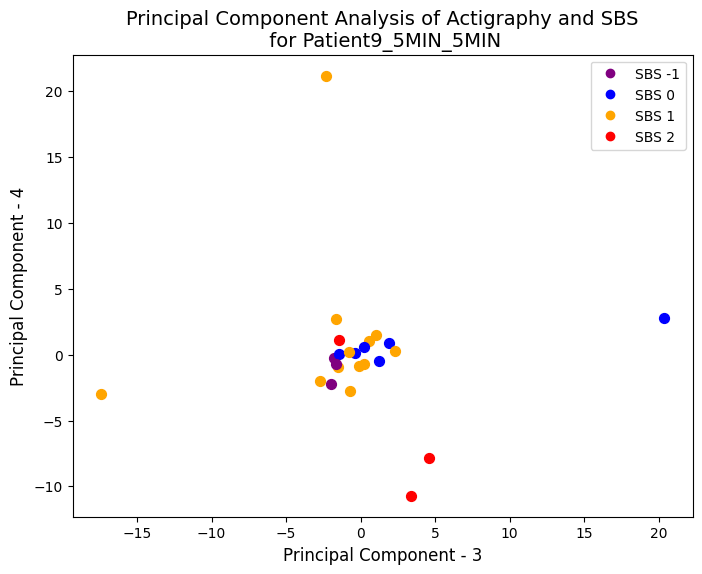

In [5]:
#There is no error handling in place, the .mat file must exist
for patient in os.listdir(data_dir):
        # filter out non-directories
        patient_dir = os.path.join(data_dir, patient)
        if os.path.isdir(patient_dir):
            data_filepath = os.path.join(patient_dir, f'{patient}_{lead_time}MIN_{slice_size_min - lead_time}MIN.mat')           
        #Can change data
        data = loadmat(data_filepath)
        x_mag = data["x_mag"]
        SBS = data["sbs"]
        #%%
        # Generate configuration file for feature extraction

        #*****************Create a new cfg file for every metric to add to PCA
        MAD_cfg_file = tsfel.get_features_by_domain()
        HR_cfg_file = tsfel.get_features_by_domain()

        print(x_mag.shape)

        #%%
        # Extract features and restructure data
        MAD_features_list = []
        HR_features_list = []
        sbs_list = []
        for i in range(x_mag.shape[0]):
            MAD = Actigraph_Metrics.VecMag_MAD(x_mag[i,:],100)

            #***********Replace with HR, this is a test and uses 2 sets of MAD data instead of MAD and HR
            HR = Actigraph_Metrics.VecMag_MAD(x_mag[1,:],100) 
            HR_features = tsfel.time_series_features_extractor(HR_cfg_file, HR, fs=100, verbose=0)
            MAD_features = tsfel.time_series_features_extractor(MAD_cfg_file, MAD, fs=100, verbose=0)

            MAD_features_list.append(MAD_features)
            HR_features_list.append(HR_features)
            sbs_list.append(SBS[0][i])

        MAD_features_array = np.array(MAD_features_list).reshape(-1, 389)
        MAD_df_features = pd.DataFrame(MAD_features_array)
        MAD_df_features.columns = ['MAD_feature_' + str(col) for col in MAD_df_features.columns]

        #********create these data frames for every new feature
        HR_features_array = np.array(HR_features_list).reshape(-1, 389)
        HR_df_features = pd.DataFrame(HR_features_array)
        HR_df_features.columns = ['HR_feature_' + str(col) for col in HR_df_features.columns]

        df_sbs = pd.DataFrame({'SBS': sbs_list})
        
        #********Concatenate all features and SBS scores
        df_features = pd.concat([MAD_df_features, HR_df_features], axis =1)
        df = pd.concat([df_sbs, df_features], axis=1)
        x = df_features.values
        y = df['SBS'].values   
        
        # Normalize features
        features = np.hstack((HR_df_features.columns ,MAD_df_features.columns))
        #print(f'feature list: {features}')
        x = df_features.iloc[:, 1:].values
        x_normalized = StandardScaler().fit_transform(x)
        print(x)
        print(f'x mean should be 0 but is really: {np.mean((x_normalized))}')
        
        # Perform PCA Using All Features
        pca_actigraphy = PCA(n_components=4)
        principalComponents_actigraphy = pca_actigraphy.fit_transform(x_normalized)
        principal_actigraphy_Df = pd.DataFrame(data=principalComponents_actigraphy,
                                            columns=['principal component 1', 'principal component 2', 'principal component 3', 'principal component 4'])

        print('Explained variation per principal component: {}'.format(pca_actigraphy.explained_variance_ratio_))

        # Plot PCA for each principal component
        for component in range(pca_actigraphy.n_components_ - 1):
            plt.figure(figsize=(8, 6))
            plt.xlabel(f'Principal Component - {component+1}', fontsize=12)
            plt.ylabel('Principal Component - {}'.format(component+2), fontsize=12)
            plt.title(f'Principal Component Analysis of Actigraphy and SBS\n for {patient}_{lead_time}MIN_{slice_size_min - lead_time}MIN', fontsize=14)
            
            for i in range(len(df_sbs)):
                if df['SBS'][i] == -1:
                    color = 'purple'
                elif df['SBS'][i] == 0:
                    color = 'blue'
                elif df['SBS'][i] == 1:
                    color = 'orange'
                elif df['SBS'][i] == 2:
                    color = 'red'
                plt.scatter(principal_actigraphy_Df.loc[i, f'principal component {component+1}'], 
                            principal_actigraphy_Df.loc[i, f'principal component {component+2}'], 
                            c=color, s=50)
            
            # Manually create a legend
            neg1 = mlines.Line2D([], [], color='purple', marker='o', ls='', label='SBS -1')
            zero = mlines.Line2D([], [], color='blue', marker='o', ls='', label='SBS 0')
            one = mlines.Line2D([], [], color='orange', marker='o', ls='', label='SBS 1')
            two = mlines.Line2D([], [], color='red', marker='o', ls='', label='SBS 2')
            plt.legend(handles=[neg1, zero, one, two])
            
            plt.show()